In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from itertools import combinations 

%matplotlib notebook

In [2]:
def filt(d, fs):
    # 50Hz notch
    b, a = signal.iirnotch(50, 100, fs)
    fl_d1 = signal.lfilter(b, a, d)

    b, a = signal.iirnotch(100, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(150, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(200, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(250, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    # bandpass filter 30 to 200Hz
    b, a = signal.butter(3, [30 / (0.5 * fs), 200 / (0.5 * fs)], btype='band')
    fl_d1 = signal.lfilter(b, a, fl_d1)
    
    return fl_d1


def readFile(fn):
    print("Reading:",fn)
    #Read data
    with open(fn) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Clean data
    d = [] # time, CH1, CH2, .., button
    for i in content:
        i = i[1:-1].split(",")
        if len(i) == 11:
            try:
                t1 = [float(_) for _ in i]
                d.append(t1)
            except:
                pass

    # numpyconvert
    d = np.array(d).swapaxes(0, 1)

    # scale and remove dc
    d[0] = d[0] / 10**6
    for i in [1,2,3,4,5,6,7,8]:
        d[i] -= np.mean(d[i])
        
    # stats
    t_d = np.diff(d[0])
    #print(np.mean(t_d)-np.std(t_d), np.mean(t_d)+np.std(t_d))

    # technically wrong, but using anyways
    # please resample properly

    fs = 1/np.mean(t_d)
    
    button = np.convolve(d[-2], [1/1000.0]*1000, "same")
    button[button > 0.1] = 1
    button[button <= 0.1] = 0

    #print(fs)
    
    return np.array([d[0]] + [filt(d[2], fs)] + [filt(x, fs) for x in d[4:9]] + [button])
    
    

In [3]:
def window_rms(a, window_size=2):
    return np.sqrt(sum([a[window_size-i-1:len(a)-i]**2 for i in range(window_size-1)])/window_size)

def feat(x):
    # extract a feature from list x
    return np.max(window_rms(x, 20))
    
def extract_feat(x, f):
    # get button on pos
    xt = np.diff(x[-1])
    st = np.array(np.where(xt == 1))[0]
    
    en = np.array(np.where(xt == -1))[0]
    print(len(st), len(en))
    le = np.array(en - st)
    val = np.array(np.where(le > 500))[0]
    start = st[val]
    end = en[val]
    
    feat = []
    for i in range(len(start)):
        temp = []
        for j in range(6):
            temp.append(f(x[1+j][start[i] - 500:end[i] + 500]))
        feat.append(temp)
    return np.array(feat)

In [4]:
files = ["b_back_" + str(i) + ".txt" for i in range(1,6)]
#files = ["index.txt", "middle.txt", "ring.txt", "little.txt"]
read_dat = [readFile(_) for _ in files]
feats = [extract_feat(_, feat) for _ in read_dat]

Reading: b_back_1.txt
Reading: b_back_2.txt
Reading: b_back_3.txt
Reading: b_back_4.txt
Reading: b_back_5.txt
79 79
100 100
125 125
125 125
153 153


In [5]:
for i in feats:
    print(len(i), i[0])

79 [146.06451112 127.05892024  49.62049944 146.85383755 174.71173775
  54.79624739]
100 [282.8732317  168.57477828  72.35691448 146.96727246 231.73611601
  80.4610356 ]
125 [274.8156394  102.20999792 103.62236378 213.70994631 121.64191416
  95.72627922]
125 [ 70.248493   144.85789648 270.9912722  155.12766283 162.53951082
 108.26190242]
153 [119.79987113 173.66094302  88.59809831 121.67759338 107.03046174
  74.0709142 ]


<IPython.core.display.Javascript object>


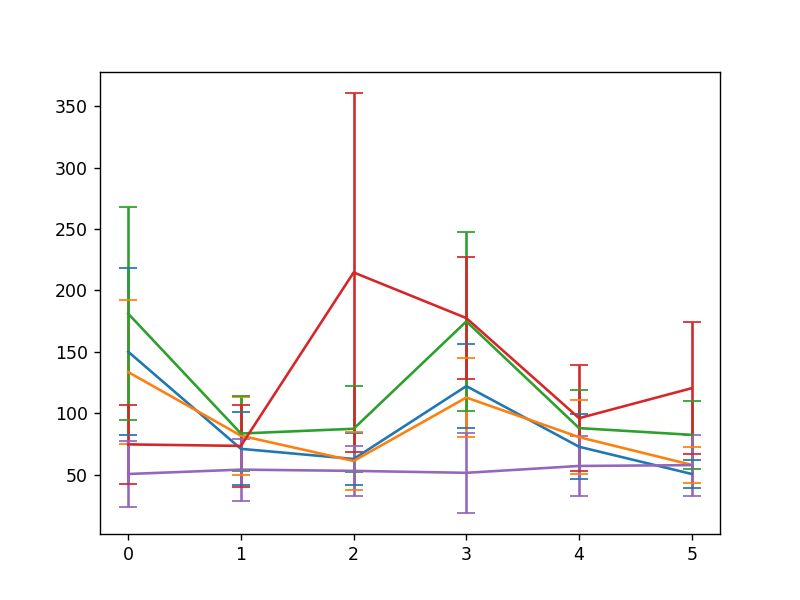

In [6]:
plt.figure()

colors = ["green", "red", "yellow", "blue", "orange"]

for ci,fe in enumerate(feats):
    fe = fe.swapaxes(0,1)
    #print(np.mean(fe, 1), np.std(fe, 1))
    plt.errorbar(range(6), np.mean(fe, 1), np.std(fe, 1), capsize=5)
    
    #for i in range(len(fe)):
    #    plt.plot(range(6), fe[i], "*", color = colors[ci])

plt.show()

In [7]:
def getAccuracy(X, y, r = 0.5, repeat = 1000): #r is test train split 0.5 => equal division
    train_acc_arr, test_acc_arr = [], []
    for _ in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)

        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)

        res = clf.predict(X_train) - y_train
        train_acc = len(np.where(res == 0)[0])*100/len(res)

        res = clf.predict(X_test) - y_test
        test_acc = len(np.where(res == 0)[0])*100/len(res)
        
        train_acc_arr.append(train_acc)
        test_acc_arr.append(test_acc)
    return (np.mean(train_acc_arr), np.mean(test_acc_arr))

In [8]:
def getXy(feats, channels, ratio_i = None):
    X, y = [], []
    for ci,fe in enumerate(feats):
        for i in range(len(fe)):
            y.append(ci)
            
            fep = []
            for chi in channels:
                 fep.append(fe[i][chi])
            if not ratio_i is None:
                div = fep.pop(ratio_i)
            else:
                div = 1.0
            X.append(np.array(fep)/div)
    return X,y

In [9]:
dat = []
for chn in range(1, 7):
    tdat = []
    for chs in list(combinations([0,1,2,3,4,5], chn)):
        for chir in range(len(chs)):
            if len(chs) == 1: chir = None
            tdat.append([chs, chir, getAccuracy(*getXy(feats, chs, chir), r = 0.2)])
            print(tdat[-1])
    dat.append(tdat)

[(0,), None, (70.71956989247312, 44.46837606837606)]
[(1,), None, (50.873548387096776, 25.847863247863245)]
[(2,), None, (63.04666666666667, 43.217948717948715)]
[(3,), None, (70.20924731182797, 46.92136752136752)]
[(4,), None, (52.020430107526884, 28.342735042735043)]
[(5,), None, (56.04193548387097, 37.24273504273505)]
[(0, 1), 0, (44.00344086021505, 43.16153846153847)]
[(0, 1), 1, (45.82430107526882, 44.868376068376065)]
[(0, 2), 0, (53.489892473118275, 53.01282051282052)]
[(0, 2), 1, (54.4210752688172, 52.05470085470086)]
[(0, 3), 0, (42.67698924731182, 40.45213675213675)]
[(0, 3), 1, (43.245591397849466, 41.22564102564103)]
[(0, 4), 0, (41.07720430107527, 39.25555555555556)]
[(0, 4), 1, (42.272903225806445, 39.73418803418803)]
[(0, 5), 0, (46.67763440860216, 43.9957264957265)]
[(0, 5), 1, (49.63892473118279, 46.758974358974356)]
[(1, 2), 0, (43.20623655913978, 42.5034188034188)]
[(1, 2), 1, (42.97032258064517, 42.23418803418804)]
[(1, 3), 0, (48.71806451612903, 47.88290598290598)]

[(1, 3, 4, 5), 0, (59.44215053763441, 57.450427350427354)]
[(1, 3, 4, 5), 1, (57.16193548387097, 55.9991452991453)]
[(1, 3, 4, 5), 2, (60.32150537634408, 57.592307692307685)]
[(1, 3, 4, 5), 3, (60.89741935483871, 57.8034188034188)]
[(2, 3, 4, 5), 0, (63.02795698924731, 60.71452991452991)]
[(2, 3, 4, 5), 1, (57.05677419354839, 56.41025641025641)]
[(2, 3, 4, 5), 2, (61.807096774193546, 58.889743589743595)]
[(2, 3, 4, 5), 3, (62.976559139784946, 59.618803418803424)]
[(0, 1, 2, 3, 4), 0, (64.67978494623655, 62.258974358974356)]
[(0, 1, 2, 3, 4), 1, (67.63505376344087, 65.58034188034188)]
[(0, 1, 2, 3, 4), 2, (67.84193548387097, 63.74273504273505)]
[(0, 1, 2, 3, 4), 3, (65.44688172043011, 64.24358974358974)]
[(0, 1, 2, 3, 4), 4, (68.21225806451612, 64.7948717948718)]
[(0, 1, 2, 3, 5), 0, (66.70301075268816, 64.49999999999999)]
[(0, 1, 2, 3, 5), 1, (70.16193548387096, 68.38717948717948)]
[(0, 1, 2, 3, 5), 2, (70.16774193548387, 66.90769230769232)]
[(0, 1, 2, 3, 5), 3, (67.54795698924731, 65.

In [10]:
Xx, Yy = [], []
M_X = []
for ci, i in enumerate(dat):
    MxX, MxV = None, None
    for j in i:
        Xx.append(ci+1)
        Yy.append(j[2][1])
        if MxV is None or MxV < j[2][1]:
            MxV = j[2][1]
            MxX = j
    M_X.append(MxX[2][1])
    print(MxX)
print(M_X)

[(3,), None, (70.20924731182797, 46.92136752136752)]
[(0, 2), 0, (53.489892473118275, 53.01282051282052)]
[(1, 2, 3), 1, (63.23784946236559, 62.082905982905984)]
[(0, 1, 3, 5), 3, (68.63677419354839, 66.03076923076922)]
[(0, 1, 2, 3, 5), 4, (71.32946236559138, 68.92649572649572)]
[(0, 1, 2, 3, 4, 5), 5, (72.61161290322582, 69.22820512820512)]
[46.92136752136752, 53.01282051282052, 62.082905982905984, 66.03076923076922, 68.92649572649572, 69.22820512820512]


<IPython.core.display.Javascript object>


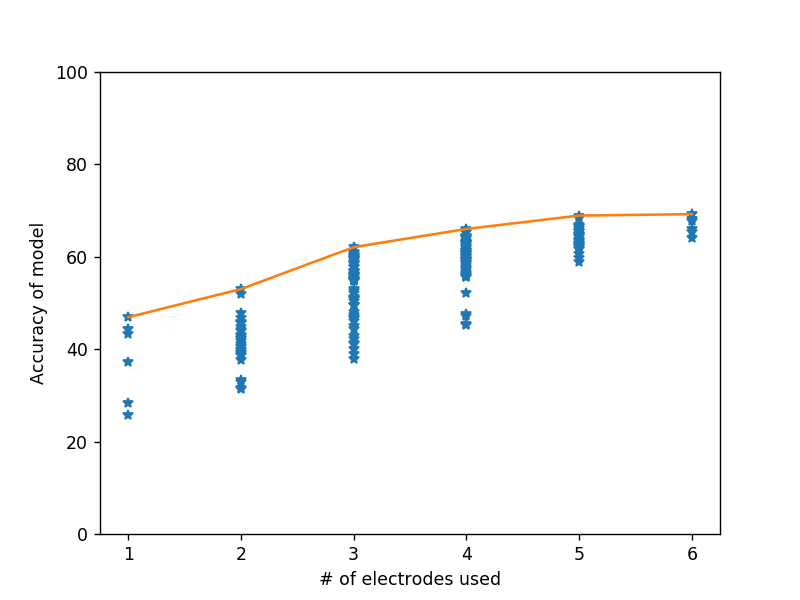

In [11]:
plt.figure()
plt.plot(Xx, Yy, "*")
plt.plot(range(1,7), M_X, "-")
plt.xlabel("# of electrodes used")
plt.ylabel("Accuracy of model")
plt.ylim([0,100])
plt.show()